# The study for HMC BIW PROJECT  

## M/L is used to estimate the value with parameters.  
## 


In [1]:
# import libraries
from __future__ import absolute_import, division, print_function, unicode_literals

# tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

# other utiles
import matplotlib.pyplot as plt
from  IPython import display
import numpy as np
import pandas as pd
import seaborn as sns
import pathlib

In [2]:
# check the tensorflow version
print(tf.__version__)

2.1.0


# Pre-Checking Dataframe


In [339]:
#------------------------------------------------------
# read training dataset
#------------------------------------------------------
dir = r"F:\CON_2019_HMC_PGD-MINESET\0_MODEL\Zone\machineLearning\ITER_2000"
csv = dir+r"\training_data2.csv"
dataset = pd.read_csv(csv)
# dataset = dataset[dataset.Intrusion < 115]
dataset.head()


,Train,p1,p2,p3,p4,p7,p8,p9,p10,Intrusion,Area
0,1,193.678511,50.974878,56.657004,127.193789,138.620307,42.077307,108.559538,110.427250,103.503174,2.809078
1,2,139.250786,80.555862,64.348697,37.767658,157.430219,165.159790,60.909341,70.166108,112.223633,2.810324
2,3,59.060636,169.646628,69.288772,68.998092,101.026681,147.962631,162.208917,36.224921,105.853577,2.792549
3,4,176.496336,177.758908,26.135000,182.826127,139.225299,108.033986,61.326045,111.138772,100.163086,2.793109
4,5,110.318064,198.036840,63.023811,142.524503,76.898240,90.950332,73.785577,95.766715,114.935242,2.803706


In [340]:
# extract the columns from the dataset
column_names = dataset.columns
# print("parameters      : {}".format(column_names[1:9]))
# print("output_curves   : {}".format(column_names[9:30]))
# print("output_Intrusion: {}".format(column_names[30]))
# print("output_Area     : {}".format(column_names[31]))
# print("output_region   : {}".format(column_names[32]))


In [341]:
# pop of first column: train Maker
dataset.pop(column_names[0])
dataset.head()


,p1,p2,p3,p4,p7,p8,p9,p10,Intrusion,Area
0,193.678511,50.974878,56.657004,127.193789,138.620307,42.077307,108.559538,110.427250,103.503174,2.809078
1,139.250786,80.555862,64.348697,37.767658,157.430219,165.159790,60.909341,70.166108,112.223633,2.810324
2,59.060636,169.646628,69.288772,68.998092,101.026681,147.962631,162.208917,36.224921,105.853577,2.792549
3,176.496336,177.758908,26.135000,182.826127,139.225299,108.033986,61.326045,111.138772,100.163086,2.793109
4,110.318064,198.036840,63.023811,142.524503,76.898240,90.950332,73.785577,95.766715,114.935242,2.803706


In [342]:
#seperate data as region
# dataset_2 = dataset[dataset['region']==0]
# dataset_3 = dataset[dataset['region']==1]


In [343]:
# dataset_3[column_names[1]]

In [344]:
# Checking: min/max for each dataset
lst_max = (dataset.max(0))
lst_min = (dataset.min(0))

# lst_max_2 = (dataset_2.max(0))
# lst_min_2 = (dataset_2.min(0))

# lst_max_3 = (dataset_3.max(0))
# lst_min_3 = (dataset_3.min(0))

# print("max={}, min={} of first Column".format(lst_max_3[-3],lst_min_3[-3] ))

# M/L model

In [345]:
# Define functions

def norm(x, train_stats):
  stats=train_stats
  return (x - stats['mean']) / stats['std']

model = None
def build_model(iunit, ounit, train_dataset,activation="sigmoid",loss='binary_crossentropy',metrics=['accuracy']):
    model = keras.Sequential([
      layers.Dense(iunit, activation='relu', 
                   kernel_regularizer=keras.regularizers.l2(0.01), 
                   input_shape=[len(train_dataset.keys())]),
      layers.Dense(iunit, activation='relu', 
                   kernel_regularizer=keras.regularizers.l2(0.001)
                   ), 
      # layers.Dense(iunit, activation='relu', 
      #              kernel_regularizer=keras.regularizers.l2(0.001)
      #              ),                     
      # layers.Dense(iunit, activation='relu', 
      #              kernel_regularizer=keras.regularizers.l2(0.001)
      #              ),                    
      layers.Dense(ounit,activation=activation)
      ])
    # optimizer = tf.keras.optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)
    #optimizer = tf.keras.optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
    #optimizer = tf.keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    #optimizer = tf.keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
    optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    # optimizer = tf.keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    #optimizer = tf.keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
    
    model.compile(
      loss=loss, #'mse', #'binary_crossentropy'
      optimizer=optimizer,
      # 'mae', 'mse', 'mape','accuracy'
      metrics=metrics)

    return model  

# Training
def training(EPOCHS=1000, model=model, normed_train_data=None, train_labels=None,verbose=0,monitor='accuracy',patience=5 ):
    model=model
    # history = model.fit(
    #                       normed_train_data, train_labels,
    #                       epochs=EPOCHS, validation_split = 0.2, verbose=verbose,
    #                       callbacks=[tfdocs.modeling.EpochDots()]
    #                       # callbacks=[keras.callbacks.TensorBoard(log_dir=dir+r'\logs')]
    #                       )
    print("% : Training : end", model) 
    early_stop = keras.callbacks.EarlyStopping(monitor=monitor, patience=patience) #loss,accuracy,val_loss,val_accuracy
    early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.4, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()]
                    # callbacks=[keras.callbacks.TensorBoard(log_dir=dir+r'\logs')]
                    )  

    return model, early_history   
                              

In [346]:
train_dataset = dataset.sample(frac=0.7)
test__dataset  = dataset.drop(train_dataset.index)

# train_dataset_2 = dataset_2.sample(frac=0.7)
# test__dataset_2  = dataset_2.drop(train_dataset_2.index)

# train_dataset_3 = dataset_3.sample(frac=0.7)
# test__dataset_3  = dataset_3.drop(train_dataset_3.index)




In [347]:

# train_dataset_3

In [348]:
# # make an instance for dataframe as "train_stats"
train_stats = train_dataset.describe()

# train_stats_2 = train_dataset_2.describe()
# train_stats_3 = train_dataset_3.describe()

# train_stats_3.head()


In [349]:
# # delete "Area" column from "train_stats"
for col in column_names[9:33]:
    train_stats.pop(col)
    # train_stats_2.pop(col)
    # train_stats_3.pop(col)

train_stats   = train_stats.transpose()    
# train_stats_2 = train_stats_2.transpose()
# train_stats_3 = train_stats_3.transpose()



In [350]:
# train_stats_3
train_dataset.head()
# label = train_dataset.loc[:,'Intrusion']
# label

,p1,p2,p3,p4,p7,p8,p9,p10,Intrusion,Area
470,165.089039,52.793466,28.094145,179.706081,115.026009,81.281215,179.697915,195.289891,94.330139,2.773604
926,64.610187,184.692855,35.940992,160.277618,57.782879,198.857612,133.872453,63.274095,110.429932,2.818266
945,129.389213,90.160581,164.333608,73.621466,158.824283,58.888677,196.329985,185.163136,105.539490,2.800872
1648,52.837569,167.803114,103.536517,50.408559,39.708058,73.900631,81.186287,143.854863,107.347717,2.819455
857,125.990698,86.874549,49.884723,105.766216,48.721819,62.581388,195.128822,124.762674,99.420166,2.793005


In [351]:
# make instances for dataset without the QoI
# train_labels_Reg    = train_dataset.loc[:,'region']
# test__labels_Reg    = test__dataset.loc[:,'region']
train_labels_Intr   = train_dataset.loc[:,'Intrusion']
test__labels_Intr   = test__dataset.loc[:,'Intrusion']
train_labels_Area   = train_dataset.loc[:,'Area']
test__labels_Area   = test__dataset.loc[:,'Area']

# train_labels_Intr_2 = train_dataset_2.loc[:,'Intrusion']
# test__labels_Intr_2 = test__dataset_2.loc[:,'Intrusion']
# train_labels_Area_2 = train_dataset_2.loc[:,'Area']
# test__labels_Area_2 = test__dataset_2.loc[:,'Area']

# train_labels_Intr_3 = train_dataset_3.loc[:,'Intrusion']
# test__labels_Intr_3 = test__dataset_3.loc[:,'Intrusion']
# train_labels_Area_3 = train_dataset_3.loc[:,'Area']
# test__labels_Area_3 = test__dataset_3.loc[:,'Area']

for i in range(9,11):    
    train_dataset.pop(column_names[i])
    test__dataset.pop(column_names[i])
    # train_dataset_2.pop(column_names[i])
    # test__dataset_2.pop(column_names[i])
    # train_dataset_3.pop(column_names[i])
    # test__dataset_3.pop(column_names[i])        

normed_train_data   = norm( train_dataset,  train_stats   )
normed_test__data   = norm( test__dataset,  train_stats   )
# normed_train_data_2 = norm( train_dataset_2,train_stats_2 )
# normed_test__data_2 = norm( test__dataset_2,train_stats_2 )
# normed_train_data_3 = norm( train_dataset_3,train_stats_3 )
# normed_test__data_3 = norm( test__dataset_3,train_stats_3 )  




In [352]:
# train_dataset_2.head()

## M/L for region

In [353]:
# from tensorflow.keras.utils import multi_gpu_model, to_categorical
# train_labels_Reg = to_categorical(train_labels_Reg)

In [354]:
# # tensorboard
# # %load_ext tensorboard
# %reload_ext tensorboard
# %tensorboard --logdir=dir+r"\logs" --port 6060

In [355]:
# # create the model instance 
# EPOCHS = 1000
# nPar = 64
# nOut = 2
# iunit = nPar * nOut
# ounit = nOut
# print("nPar: {}, nOut: {}, iunit: {}, ounit: {}".format(nPar,nOut,iunit,ounit))

# # from tensorflow.keras.utils import multi_gpu_model, to_categorical
# # train_labels_Reg = to_categorical(train_labels_Reg)
# model_Reg = build_model(iunit, ounit, train_dataset,activation='sigmoid',loss='mse',metrics=['accuracy'])
# model_Reg, model_Reg_history, model_Reg_early_history = training(EPOCHS, model_Reg, normed_train_data, train_labels_Reg, verbose=0, monitor='accuracy', patience=5)
# model_Reg.save(dir+r'\trainingdata_Intr_for_Zone_Reg.h5')

In [356]:
# test__labels_Reg = to_categorical(test__labels_Reg)
# # test_labels__Reg


In [357]:
# test_mae_score_Reg, test_mae_score1_Reg = model_Reg.evaluate(  normed_test__data, test__labels_Reg  )
# print(test_mae_score_Reg, test_mae_score1_Reg)

In [358]:
# train_predictions = model_Reg.predict(normed_train_data).flatten()
# test__predictions = model_Reg.predict(normed_test__data).flatten()
# print(type(train_predictions))
# print("{},{}".format(len(train_predictions),len(train_labels_Reg)))
# train_value=[]
# test__value=[]
# for i in range(0,len(train_predictions)-1):
#     if i % 2 == 0:
#         if train_predictions[i] < train_predictions[i+1] :
#             train_value.append(1)
#         else:
#             train_value.append(0)
# for i in range(0,len(test__predictions)-1):
#     if i % 2 == 0:           
#         if test__predictions[i] < test__predictions[i+1] :
#             test__value.append(1)
#         else:
#             test__value.append(0)            
# train_predictions = np.array(train_value)  
# test__predictions = np.array(test__value) 

In [359]:
# print("{},{}".format(len(train_labels_Reg),len(train_predictions)))
# print("{},{}".format(len(test__labels_Reg),len(test__predictions)))
# train_predictions = to_categorical(train_predictions)
# test__predictions = to_categorical(test__predictions)

# print("dtype: {},{}".format(train_labels_Reg.dtype,  train_predictions.dtype))
# print("ndim:  {},{}".format(train_labels_Reg.ndim,   train_predictions.ndim))
# print("size:  {},{}".format(train_labels_Reg.size,   train_predictions.size))
# print("nbytes:{},{}".format(train_labels_Reg.nbytes, train_predictions.nbytes))



In [360]:

# print("{},{}".format(len(train_labels_Reg),len(train_predictions)))
# print("{},{}".format(len(test__labels_Reg),len(test__predictions)))

# plt.scatter(train_labels_Reg, train_predictions)
# plt.scatter(test__labels_Reg, test__predictions )
# plt.xlabel('True Values [Reg]')
# plt.ylabel('Predictions [Reg]')
# plt.axis('equal')
# plt.axis('square')
# plt.xlim([0,plt.xlim()[1]])
# plt.ylim([0,plt.ylim()[1]])
# _ = plt.plot([0, 150], [0, 150])

In [361]:
# test_predictions
# error = test__predictions - test__labels_Reg

# plt.hist(error, bins = 25)
# plt.xlabel("Prediction Error [region]")
# _ = plt.ylabel("Count")

In [362]:
# train_dataset.to_csv(r"F:\CON_2019_HMC_PGD-MINESET\Zone5_mat590\DROP_SIMUL_200\train_dataset.csv")
# test_dataset.to_csv(r"F:\CON_2019_HMC_PGD-MINESET\Zone5_mat590\DROP_SIMUL_200\test_dataset.csv")

# pd.DataFrame(train_predictions).to_csv(dir+r"\train_pred_region.csv")
# pd.DataFrame(test__predictions).to_csv(dir+r"\test__pred_region.csv")


In [363]:
# plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
# plotter.plot({'Basic': model_Reg_history}, metric = "loss")
# plt.ylim([0, 1])
# plt.ylabel('loss')

In [364]:
# # 모델 학습 과정 표시하기
# %matplotlib inline
# import matplotlib.pyplot as plt

# fig, loss_ax = plt.subplots()
# acc_ax = loss_ax.twinx()
# hist = model_Reg_early_history
# loss_ax.plot(hist.history['loss'], 'y', label='train loss')
# loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

# acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
# acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

# loss_ax.set_xlabel('epoch')
# loss_ax.set_ylabel('loss')
# acc_ax.set_ylabel('accuray')

# loss_ax.legend(loc='upper left')
# acc_ax.legend(loc='lower left')

# plt.show()

## M/L for Intursion without classification

In [365]:
# # create the model instance 
EPOCHS = 5000
nPar = 8
nOut = 1
iunit = nPar * nOut
ounit = nOut
print("nPar: {}, nOut: {}, iunit: {}, ounit: {}".format(nPar,nOut,iunit,ounit))
model_Intr = build_model(iunit, ounit, train_dataset,activation=None,loss='mape',metrics=['mape'])
model_Intr, model_Intr_early_history = training(EPOCHS, model_Intr, normed_train_data, train_labels_Intr, verbose=0, monitor='mape', patience=5)


model_Intr.save(dir+r'\trainingdata_Intr_for_Zone.h5')

nPar: 8, nOut: 1, iunit: 8, ounit: 1
% : Training : end <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001FC51117308>

Epoch: 0, loss:100.2646,  mape:100.1830,  val_loss:99.9958,  val_mape:99.9153,  
....................................................................................................
Epoch: 100, loss:5.5222,  mape:5.2535,  val_loss:6.1700,  val_mape:5.9032,  
....................................................................................

In [366]:
test_mae_score_Intr, test_mae_score1_Intr = model_Intr.evaluate(  normed_test__data, test__labels_Intr  )
print(test_mae_score_Intr, test_mae_score1_Intr)

600/600 [==============================] - 0s 27us/sample - loss: 4.4086 - mape: 4.2363
4.408614317576091 4.23628


1400,1400


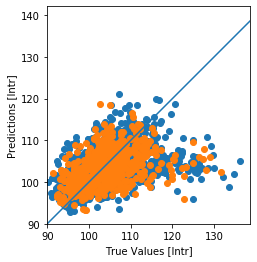

In [367]:
train_predictions = model_Intr.predict(normed_train_data).flatten()
test__predictions = model_Intr.predict(normed_test__data).flatten()
print("{},{}".format(len(train_predictions),len(train_labels_Intr)))
plt.scatter(train_labels_Intr, train_predictions)
plt.scatter(test__labels_Intr, test__predictions )

plt.xlabel('True Values [Intr]')
plt.ylabel('Predictions [Intr]')
plt.axis('equal')
plt.axis('square')
plt.xlim([90,plt.xlim()[1]])
plt.ylim([90,plt.ylim()[1]])
# plt.xlim([90,120])
# plt.ylim([90,120])
_ = plt.plot([0, 150], [0, 150])

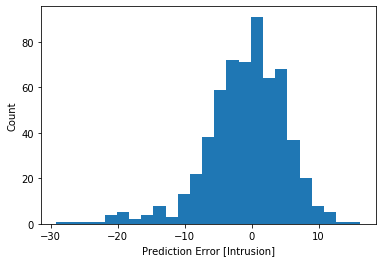

In [368]:
# train_predictions = np.array(train_value)  
# test_predictions  = np.array(test__value) 
# print("size:  {},{}".format(len(test_predictions),len(test_labels__Intr)))
# print("type:  {},{}".format(type(test_predictions),type(test_labels__Intr)))
# print("dtype: {},{}".format(test_labels__Intr.dtype,  test_predictions.dtype))
# print("ndim:  {},{}".format(test_labels__Intr.ndim,   test_predictions.ndim))
# print("size:  {},{}".format(test_labels__Intr.size,   test_predictions.size))
# print("nbytes:{},{}".format(test_labels__Intr.nbytes, test_predictions.nbytes))
# data = test__labels_Intr.iloc[0]
# print(type(data))
error = test__predictions - test__labels_Intr

plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Intrusion]")
_ = plt.ylabel("Count")

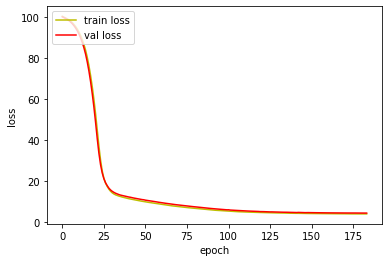

In [369]:
# 모델 학습 과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
# acc_ax = loss_ax.twinx()

hist = model_Intr_early_history
# hist = model_Intr_early_history 
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

# acc_ax.plot(hist.history['mse'], 'b', label='train mse')
# acc_ax.plot(hist.history['val_mse'], 'g', label='val mse')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
# acc_ax.set_ylabel('mse')

loss_ax.legend(loc='upper left')
# acc_ax.legend(loc='lower left')

plt.show()

In [373]:
train_dataset.to_csv(dir+r"\train_dataset_intr.csv")
test__dataset.to_csv(dir+r"\test__dataset_intr.csv")

train_labels_Intr.to_csv(dir+r"\train_labels_Intr.csv")
test__labels_Intr.to_csv(dir+r"\test__labels_Intr.csv")

pd.DataFrame(train_predictions).to_csv(dir+r"\train_pred_intr.csv")
pd.DataFrame(test__predictions).to_csv(dir+r"\test__pred_intr.csv")

Text(0, 0.5, 'MSE_Intr')

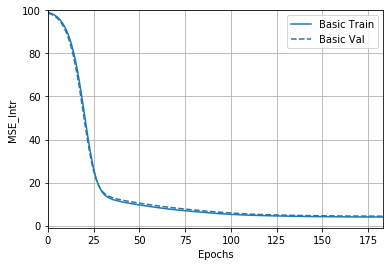

In [376]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': model_Intr_early_history}, metric = "mape")
plt.ylim([-1, 100])
plt.ylabel('MSE_Intr')

## M/L for Intursion of region_2

In [377]:
# # create the model for intusion by region_2
# EPOCHS = 5000
# nPar = 64
# nOut = 1
# iunit = nPar * nOut
# ounit = nOut
# print("nPar: {}, nOut: {}, iunit: {}, ounit: {}".format(nPar,nOut,iunit,ounit))
# model_Intr_2 = build_model(iunit, ounit, train_dataset_2, activation=None,loss='mse',metrics=['mse'])
# model_Intr_2, model_Intr_2_history, model_Intr_2_early_history = training(EPOCHS, model_Intr_2, normed_train_data_2, train_labels_Intr_2, verbose=0, monitor='mse', patience=5)

# model_Intr_2.save(dir+r'\trainingdata_Intr_for_Zone_2.h5')

In [378]:
# test_mae_score_Intr_2, test_mae_score1_Intr_2 = model_Intr_2.evaluate(  normed_test__data_2, test__labels_Intr_2  )
# print(test_mae_score_Intr_2, test_mae_score1_Intr_2)

In [379]:
# train_predictions = model_Intr_2.predict(normed_train_data_2).flatten()
# test__predictions = model_Intr_2.predict(normed_test__data_2).flatten()

# plt.scatter(train_labels_Intr_2, train_predictions)
# plt.scatter(test__labels_Intr_2, test__predictions)

# plt.xlabel('True Values [Intr_2]')
# plt.ylabel('Predictions [Intr_2]')
# plt.axis('equal')
# plt.axis('square')
# plt.xlim([90,plt.xlim()[1]])
# plt.ylim([90,plt.ylim()[1]])
# _ = plt.plot([90, 150], [90, 150])

In [380]:
# error = test__predictions - test__labels_Intr_2

# plt.hist(error, bins = 25)
# plt.xlabel("Prediction Error [Intrusion_region2]")
# _ = plt.ylabel("Count")

In [381]:
# train_dataset_2.to_csv(dir+r"\train_dataset_intr_2.csv")
# test__dataset_2.to_csv(dir+r"\test__dataset_intr_2.csv")

# pd.DataFrame(train_predictions).to_csv(dir+r"\train_pred_intr_2.csv")
# pd.DataFrame(test__predictions).to_csv(dir+r"\test__pred_intr_2.csv")

In [382]:
# plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
# plotter.plot({'Basic': model_Intr_2_history}, metric = "mse")
# plt.ylim([-1, 2000])
# plt.ylabel('MSE_Intr_2')

## M/L for Intursion of region_3

In [383]:
# # # create the model for intusion by region_3
# EPOCHS = 5000
# nPar = 64
# nOut = 1
# iunit = nPar * nOut
# ounit = nOut
# print("nPar: {}, nOut: {}, iunit: {}, ounit: {}".format(nPar,nOut,iunit,ounit))
# model_Intr_3 = build_model(iunit, ounit, train_dataset_3, activation=None,loss='mse',metrics=['mse'])
# model_Intr_3, model_Intr_3_history, model_Intr_3_early_history = training(EPOCHS, model_Intr_3, normed_train_data_3, train_labels_Intr_3, verbose=0, monitor='mse', patience=5)

# model_Intr_3.save(dir+r'\trainingdata_Intr_for_Zone_3.h5')

In [384]:
# plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
# plotter.plot({'Basic': model_Intr_3_history}, metric = "mse")
# plt.ylim([-1, 500])
# plt.ylabel('MSE_Intr_3')

In [385]:
# test_mae_score_Intr_3, test_mae_score1_Intr_3 = model_Intr_3.evaluate(  normed_test__data_3, test__labels_Intr_3  )
# print(test_mae_score_Intr_3, test_mae_score1_Intr_3)

In [386]:
# train_predictions = model_Intr_3.predict(normed_train_data_3).flatten()
# test__predictions = model_Intr_3.predict(normed_test__data_3).flatten()

# plt.scatter(train_labels_Intr_3, train_predictions)
# plt.scatter(test__labels_Intr_3, test__predictions)

# plt.xlabel('True Values [Intr_3]')
# plt.ylabel('Predictions [Intr_3]')
# plt.axis('equal')
# plt.axis('square')
# plt.xlim([90,plt.xlim()[1]])
# plt.ylim([90,plt.ylim()[1]])
# _ = plt.plot([90, 150], [90, 150])

In [387]:
# error = test__predictions - test__labels_Intr_3

# plt.hist(error, bins = 25)
# plt.xlabel("Prediction Error [Intrusion_region3]")
# _ = plt.ylabel("Count")

In [388]:
# train_dataset_3.to_csv(dir+r"\train_dataset_intr_3.csv")
# test__dataset_3.to_csv(dir+r"\test__dataset_intr_3.csv")

# pd.DataFrame(train_predictions).to_csv(dir+r"\train_pred_intr_3.csv")
# pd.DataFrame(test__predictions).to_csv(dir+r"\test__pred_intr_3.csv")

## M/L for Area reduction

In [392]:
EPOCHS = 5000
nPar = 8
nOut = 1
iunit = nPar * nOut
ounit = nOut
print("nPar: {}, nOut: {}, iunit: {}, ounit: {}".format(nPar,nOut,iunit,ounit))
model_Area = build_model(iunit, ounit, train_dataset, activation=None,loss='mape',metrics=['mape'])
model_Area, model_Area_early_history = training(EPOCHS, model_Area, normed_train_data, train_labels_Area, verbose=0, monitor='mape', patience=5)
model_Area.save(dir+r'\trainingdata_Area_for_Zone.h5')

nPar: 8, nOut: 1, iunit: 8, ounit: 1
% : Training : end <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001FC50D7C608>

Epoch: 0, loss:121.2977,  mape:121.2210,  val_loss:113.1164,  val_mape:113.0412,  
....................................................................................................
Epoch: 100, loss:0.5161,  mape:0.4784,  val_loss:0.5985,  val_mape:0.5609,  
......................................

In [393]:
test_mae_score_Area, test_mae_score1_Area = model_Area.evaluate(  normed_test__data, test__labels_Area  )
print(test_mae_score_Area, test_mae_score1_Area)

600/600 [==============================] - 0s 27us/sample - loss: 0.4468 - mape: 0.4125
0.44683440804481506 0.41252977


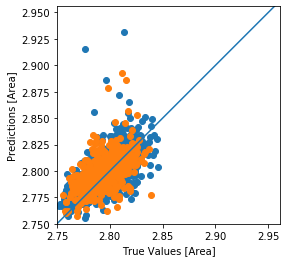

In [395]:
train_predictions = model_Area.predict(normed_train_data).flatten()
test__predictions = model_Area.predict(normed_test__data).flatten()

plt.scatter(train_labels_Area, train_predictions)
plt.scatter(test__labels_Area, test__predictions )

plt.xlabel('True Values [Area]')
plt.ylabel('Predictions [Area]')
plt.axis('equal')
plt.axis('square')
plt.xlim([2.75,plt.xlim()[1]])
plt.ylim([2.75,plt.ylim()[1]])
_ = plt.plot([-100, 1000], [-100, 1000])

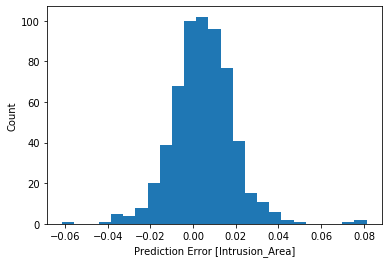

In [396]:
error = test__predictions - test__labels_Area

plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Intrusion_Area]")
_ = plt.ylabel("Count")

In [401]:
# train_dataset.to_csv(r"F:\CON_2019_HMC_PGD-MINESET\Zone5_mat590\DROP_SIMUL_200\train_dataset.csv")
# test_dataset.to_csv(r"F:\CON_2019_HMC_PGD-MINESET\Zone5_mat590\DROP_SIMUL_200\test_dataset.csv")
train_labels_Area.to_csv(dir+r"\train_labels_Area.csv")
test__labels_Area.to_csv(dir+r"\test__labels_Area.csv")

pd.DataFrame(train_predictions).to_csv(dir+r"\train_pred_area.csv")
pd.DataFrame(test__predictions).to_csv(dir+r"\test__pred_area.csv")

Text(0, 0.5, 'MSE_Area')

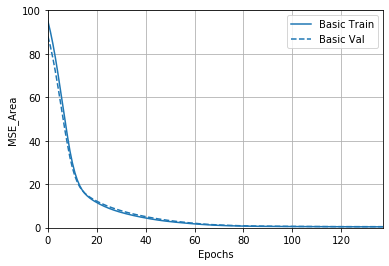

In [402]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': model_Area_early_history}, metric = "mape")
plt.ylim([-0.1, 100])
plt.ylabel('MSE_Area')

In [314]:
# plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
# plotter.plot({'Early Stopping': early_history}, metric = "mae")
# plt.ylim([-1, 10])
# plt.ylabel('MAE')

In [315]:
# study for dataframe
# data = {'a':[1,2,3.0],'b':[0.1,0.2,0.3],'sub':['1st','2nd','3nd']}
# df = pd.DataFrame(data)
# df
# df = pd.DataFrame(data, columns=['sub','a','b'])
# df
# df = df.reindex(index = [0,2,1])
# df
# df['c']=np.nan
# df
# df.loc[:,['c']]=[1,2,3]
# df

In [316]:
# model evaluate by curve
# model = keras.models.load_model(r'F:\CON_2019_HMC_PGD-MINESET\Zone5_mat590\machineLearning\trainingdata_for_Zone.h5')
# test_predictions = model.predict(normed_test_data).flatten()
# test_predictions = model.predict(normed_test_data)
# print("normed_test_data: {}".format(normed_test_data))
# print("test_dataset    : {}".format(test_dataset))
# print("test_predictions: {}".format(test_predictions))


# Optimization

In [317]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.models import Sequential, load_model
from scipy import optimize
import time


In [318]:
# Number of Curve points
point = 39
# Number of variables 
var = 8

In [319]:
# predict_func
# Mean square error between test and prediction

def predict_func( lst ):
    import math
    # # Result of prediction data 
    reg = 0 
    
    lstVar  = [ var  for var  in lst    ]

    lstVarN = [ norm(varN, train_stats) for varN in lstVar ]

    # predict_Reg  = model_Reg.predict( [lstVarN] )[0]
    predict_Intr = model_Intr.predict( [lstVarN] )[0]

    # predict_Intr_2 = model_Intr_2.predict( [lstVarN] )[0]
    # predict_Intr_3 = model_Intr_3.predict( [lstVarN] )[0]

    predict_Area = model_Area.predict( [lstVarN] )[0]

    # cVal = 0
    # sInt = 0 
    # sAre = 0
    # sReg = 0

    # for i in range(0,len(predict)):
    #     if i <= 20: # curve data
    #         cVal = cVal + predict[i]
    #     if i == 21: # max. intrusion
    #         sInt = predict[i]
    #     if i == 22: # area
    #         sAre = predict[i]
    #     if i == 23: # region
    #         sReg = predict[i]

    # lst_max = (dataset.max(0))
    # lst_min = (dataset.min(0))
    # print("max={}, min={} of first Column".format(lst_max[1],lst_min[1] ))

    # if predict_Reg[0] > predict_Reg[1] :
    #     predict_Intr = predict_Intr_2
    #     reg = 0
    # else:
    #     predict_Intr = predict_Intr_3
    #     reg = 1
    

    # if predict_Reg < 2.5:
    #     predict_Intr = predict_Intr_2
    # else:
    #     predict_Intr = predict_Intr_3

    norm_Int  = math.sqrt( ((predict_Intr - lst_min[8])/(lst_max[8] - lst_min[8]))**2 ) 
    # norm_Int_2  = math.sqrt( ((predict_Intr_2 - lst_min[29])/(lst_max[29] - lst_min[29]))**2 ) 
    # norm_Int_3  = math.sqrt( ((predict_Intr_3 - lst_min[29])/(lst_max[29] - lst_min[29]))**2 ) 

    norm_Area = math.sqrt( ((predict_Area - lst_min[9])/(lst_max[9] - lst_min[9]))**2 ) 


    # print("min: {}, max: {}".format(lst_min[30], lst_max[30]))
    print("parameter: {}".format(lstVar))
    print("norm: {},{}".format(norm_Int,norm_Area))
    print("Region: {}, Intursion: {}, Area: {}".format(reg, predict_Intr, predict_Area))

    # weight1 = 0.2


    return  norm_Int + norm_Area


In [320]:
# normed_train_data_3
print("{},{}".format(lst_min[8],lst_min[9]))

90.19281006,2.75167106


In [403]:
# 1st
bnds = [( 25, 100 ), ( 25, 100 ), ( 25, 200 ), ( 25, 200 ),
        ( 30, 300 ), ( 30, 300 ), ( 30, 200 ), ( 30, 200 )
]
from scipy import optimize
# best1bin
result_best1bin = optimize.differential_evolution(predict_func, bnds, strategy='best1bin', init='latinhypercube')
print("DONE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")


3.86963668729192, 100.36260223040483, 30.792447380969037, 128.08871116198503]
norm: 0.34958655000479066,0.6793429279565455
Region: 0, Intursion: [106.28642], Area: [2.815545]
parameter: [99.46679468806923, 87.14191856679349, 96.41384302270109, 113.23655529187708, 75.84743488741813, 62.28624270936429, 113.56984751716442, 54.65742119593105]
norm: 0.31881383041720457,0.5846329981379338
Region: 0, Intursion: [104.86977], Area: [2.8066401]
parameter: [98.20940259207845, 96.70359254984874, 134.38821835455718, 122.08580649402492, 279.69282135738956, 184.7523921750096, 47.81549444968171, 67.08658399476691]
norm: 0.3217733843129999,0.5937413666750015
Region: 0, Intursion: [105.00601], Area: [2.8074965]
parameter: [29.778719171459322, 97.70453103679037, 83.15487772517828, 151.3729092258293, 133.61136613759868, 103.55974626202297, 152.17915244550593, 135.57655746273045]
norm: 0.8364690000076425,2.5762906108618626
Region: 0, Intursion: [128.7006], Area: [2.9939022]
parameter: [70.51364003181654, 7

In [322]:
# Get minimize parameters
minimum_best1bin_x = result_best1bin.x
minimum_best1bin_f = result_best1bin.fun
minimum_best1bin_x, minimum_best1bin_f

(array([141.65061182, 124.70164814, 182.46092376, 183.46155449,
        124.93356749,  75.99973409,  80.53123054,  96.60971098]),
 0.22544185776777909)

In [323]:
#Second
bnds = [( 25, 200 ), ( 25, 200 ), ( 25, 200 ), ( 25, 200 ),
        ( 30, 200 ), ( 30, 200 ), ( 30, 200 ), ( 30, 200 )
]
from scipy import optimize
# best1bin
result_best1bin = optimize.differential_evolution(predict_func, bnds, strategy='best1bin', init='latinhypercube')
print("DONE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

9.07331722575816, 97.42501943634598, 124.42114611009583, 97.7633740281041, 110.0903480490005, 42.5626375552374, 147.0532669970865, 37.85198110417096]
norm: 0.225704533502258,0.35016816518547056
Region: 0, Intursion: [100.583374], Area: [2.784595]
parameter: [139.02568924286234, 116.81429624423814, 128.0205581526305, 87.15141506635047, 82.45007738136997, 35.88101060442236, 141.41668924255055, 97.53899898860763]
norm: 0.2257093364538242,0.35037103723659196
Region: 0, Intursion: [100.583595], Area: [2.784614]
parameter: [142.3845843078188, 105.30914281897064, 122.34323612537277, 140.84172186718524, 56.199862714077994, 171.0728724993013, 101.73143202972584, 160.78452697531372]
norm: 0.22889409960634732,0.33599084607992197
Region: 0, Intursion: [100.73021], Area: [2.783262]
parameter: [147.65292181294285, 130.61101652254862, 105.8122120992529, 99.99921221084949, 89.19191052582659, 78.75025347866867, 186.51655685859927, 41.16060605457932]
norm: 0.2541660300361498,0.313354278195839
Region: 0,

In [324]:
# 2nd: Get minimize parameters
minimum_best1bin_x = result_best1bin.x
minimum_best1bin_f = result_best1bin.fun
minimum_best1bin_x, minimum_best1bin_f

(array([141.66112683, 118.28007307, 108.6533173 , 116.92353149,
         94.84268078,  32.28808876, 146.1464154 ,  39.59564984]),
 0.2254408580396673)

In [325]:
#Third
bnds = [( 25, 200 ), ( 25, 200 ), ( 25, 200 ), ( 25, 200 ),
        ( 30, 200 ), ( 30, 200 ), ( 30, 200 ), ( 30, 200 )
]
from scipy import optimize
# best1bin
result_best1bin = optimize.differential_evolution(predict_func, bnds, strategy='best1bin', init='latinhypercube')
print("DONE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

on: 0, Intursion: [100.5893], Area: [2.7851038]
parameter: [137.765993173379, 186.8749995471636, 133.9971152654586, 133.00297586043538, 129.56167831933422, 180.81363779332202, 165.79442509491724, 149.8194522277475]
norm: 0.22583761666577248,0.3557645593949156
Region: 0, Intursion: [100.5895], Area: [2.7851212]
parameter: [140.76863848405074, 102.67300514906513, 108.31604043150216, 110.39897621501638, 179.63824558274314, 59.138570960627476, 40.08601417266708, 191.70970553897396]
norm: 0.22553184818623506,0.3429058177969262
Region: 0, Intursion: [100.575424], Area: [2.7839122]
parameter: [139.33590802449234, 123.06842683438677, 99.4924108385045, 140.4907622986931, 35.570010080653915, 126.77248495188081, 101.6232350705047, 119.78310919999448]
norm: 0.2256778513278097,0.3490422940190323
Region: 0, Intursion: [100.582146], Area: [2.7844892]
parameter: [137.60568055275294, 86.50420458602503, 72.94385089417318, 58.75520127909519, 135.5716077137443, 131.0675531112488, 106.02630792105059, 140.8

In [326]:
# 3nd: Get minimize parameters
minimum_best1bin_x = result_best1bin.x
minimum_best1bin_f = result_best1bin.fun
minimum_best1bin_x, minimum_best1bin_f

(array([141.63968548,  92.80612051,  70.75879055, 118.47506747,
        135.68111584, 117.03949566,  77.48881921, 129.91770877]),
 0.225443187977649)

In [327]:
# normed_test_data

# test_predictions = model.predict(normed_test_data)
# print("normed_test_data: {}".format(normed_test_data))
# print("test_dataset    : {}".format(test_dataset))
# print("test_predictions: {}".format(test_predictions))